## Geometric Computer Vision, Skoltech, 2021 

**Alexey Artemov, Sofia Potapova**

Plan:

    1) Camera pose and extrinsics
    
    2) Camera intrinsics and image formation
    
    3) Raycasting and depth images


# 1. Camera pose and extrinsics

### World and Camera coordinate systems

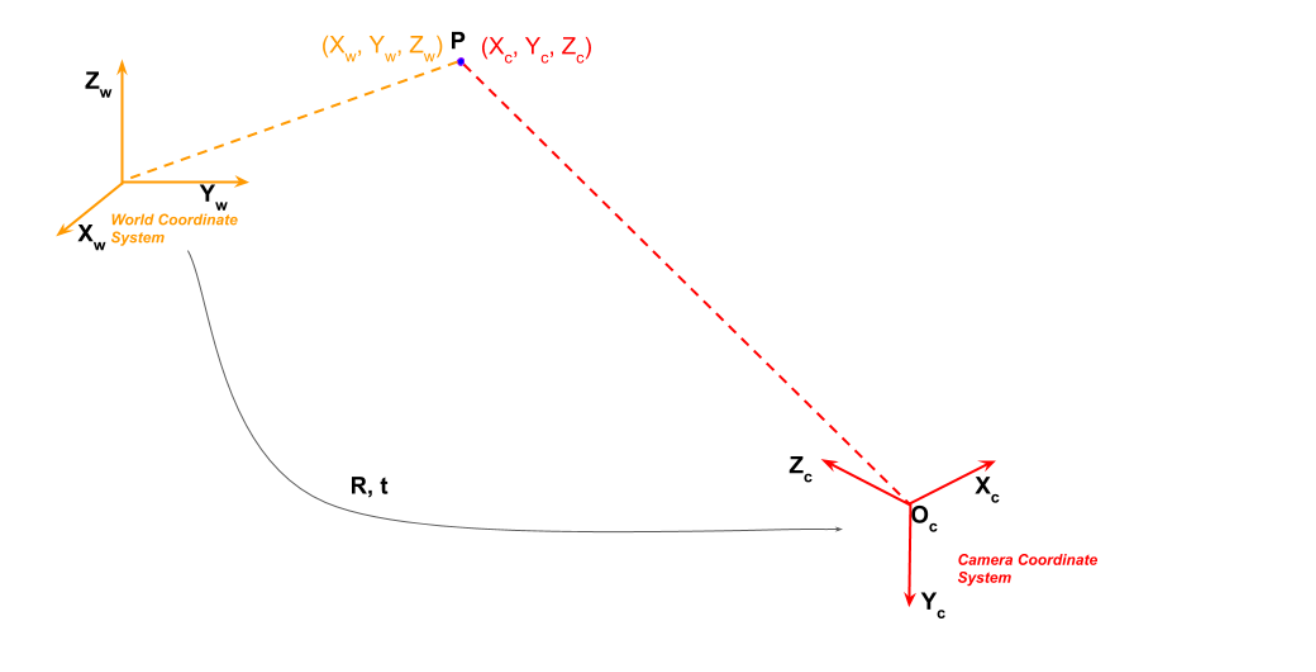

**Rotation and translation**


$$\begin{pmatrix}
X_c\\
Y_c\\
Z_c
\end{pmatrix} = R\begin{pmatrix}
X_w\\
Y_w\\
Z_w
\end{pmatrix} + t
$$


$$\begin{pmatrix}
X_c\\
Y_c\\
Z_c
\end{pmatrix} = 
\begin{pmatrix}
R | t
\end{pmatrix}
\begin{pmatrix}
X_w\\
Y_w\\
Z_w \\ 
1
\end{pmatrix}
$$


**Extrinsic Matrix**
$$P = \begin{pmatrix}
R | t
\end{pmatrix}$$

## Let's code!

In [ ]:
# !pip install trimesh==3.9.7
# !pip install k3d
# !pip install networkx==2.5
# !pip install pyglet==1.5.15
# !conda install -c conda-forge pyembree

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import math
import k3d
import trimesh
import trimesh.transformations as tt


from utils import illustrate_mesh, illustrate_points, illustrate_camera
from utils import fibonacci_sphere_sampling

### Trimesh tutorial




In [ ]:
alpha, beta, gamma = 0.123, -1.234, 2.345

origin, xaxis, yaxis, zaxis = [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1]


I = tt.identity_matrix()
Rx = tt.rotation_matrix(alpha, xaxis)
Ry = tt.rotation_matrix(beta, yaxis)
Rz = tt.rotation_matrix(gamma, zaxis)
R = tt.concatenate_matrices(Rx, Ry, Rz)

euler = tt.euler_from_matrix(R, 'rxyz')

np.allclose([alpha, beta, gamma], euler)

In [ ]:
# Euler
Re = tt.euler_matrix(alpha, beta, gamma, 'rxyz')
tt.is_same_transform(R, Re)

In [ ]:
alpla, beta, gamma = tt.euler_from_matrix(Re, 'rxyz')
tt.is_same_transform(Re, tt.euler_matrix(alpha, beta, gamma, 'rxyz'))

In [ ]:
S = tt.scale_matrix(1.23, origin)
T = tt.translation_matrix([1, 2, 3])
Z = tt.shear_matrix(beta, xaxis, origin, zaxis)
R = tt.random_rotation_matrix(np.random.rand(3))
M = tt.concatenate_matrices(T, R, Z, S)
# M = tt.concatenate_matrices(T, R)
M

In [297]:
scale, shear, angles, trans, persp = tt.decompose_matrix(M)

In [ ]:
np.allclose(scale, 1.23)

In [ ]:
np.allclose(trans, [1, 2, 3])

In [ ]:
np.allclose(shear, [0, math.tan(beta), 0])

In [ ]:
tt.is_same_transform(R, tt.euler_matrix(axes='rxyz', *angles))

In [413]:
# Euclidean norm

v = tt.random_vector(3)
tt.unit_vector(v)

array([0.7003608 , 0.42073861, 0.57660539])

### Let's check on real object

**Exercise 1:** 
1) load mesh

2) set volumetric center of mass as the origin for mesh

3) generate some points on the mesh surface

4) illusrate mesh and points using above functions

In [ ]:
mesh = <...>
illustrate_mesh(mesh)

In [ ]:
points = <...>

colors = k3d.helpers.map_colors(
    points, k3d.colormaps.basic_color_maps.Rainbow, [-3, 3]
).astype(np.uint32)
colors = colors[:, 0]


illustrate_points(points, size=0.1, colors=colors)

**Exercise 2:** sample points on the sphere around mesh (use *fibonacci_sphere_sampling*)

In [ ]:
scanning_radius = <...>

n_camera_origins = 100

# XYZ coordinates of camera frame origin in world frame
camera_origins = fibonacci_sphere_sampling(
    n_camera_origins, radius=scanning_radius, seed=42)
camera_origins[:5]

In [ ]:
# illustrate points around mesh

plot = illustrate_mesh(mesh)
illustrate_points(camera_origins, size=1., plot=plot)

**Exercise 3:** Code the following functions in CameraPose class:


1) *get_transform_matrix*

2) *transform_world_to_camera* (you can use *tt.transform_points*)

3) *transform_camera_to_world*

In [ ]:
class CameraPose:
    def __init__(self, transform):
        self._camera_to_world = transform
        # always store transform from world to camera frame
        self._world_to_camera = np.linalg.inv(self._camera_to_world)

    @classmethod
    def from_camera_to_world(cls, rotation=None, translation=None):
        """Create camera pose from camera to world transform.

        :param rotation: 3x3 rotation matrix of camera frame axes in world frame
        :param translation: 3d location of camera frame origin in world frame
        """
        
        transform = CameraPose.get_transform_matrix(rotation, translation)
        
        return cls(transform)
    

    @classmethod
    def from_camera_axes(cls, R=None, t=None):
        """Compute 4x4 camera pose from camera axes given in world frame.

        :param R: a list of 3D basis vectors (cx, cy, cz) defined in world frame
        :param t: 3D vector defining location of camera origin in world frame
        """
        if None is R:
            R = np.identity(3)

        return cls.from_camera_to_world(rotation=R.T, translation=t)
    
    
    @classmethod
    def from_camera_origin(cls, camera_origin):
        """Compute 4x4 camera pose from camera axes given in world frame.

        :param R: a list of 3D basis vectors (cx, cy, cz) defined in world frame
        :param t: 3D vector defining location of camera origin in world frame
        """
        rotation = CameraPose.get_rotation_to_world_origin(camera_origin)
        
        return cls.from_camera_to_world(rotation=rotation.T, translation=camera_origin)
    
    def transform_world_to_camera(self, points):
        """Transform points from world to camera coordinates.
        Useful for understanding where the objects are, as seen by the camera.
        :param points: either n * 3 array, or a single 3-vector
        """
        points = np.atleast_2d(points)
        
        ### Your code here ###
        
        return points

    def transform_camera_to_world(self, points):
        """Transform points from camera to world coordinates.
        Useful for understanding where objects bound to camera
        (e.g., image pixels) are in the world.
        :param points: either n * 3 array, or a single 3-vector
        :param translate: if True, also translate the points
        """
        points = np.atleast_2d(points)
        
        ### Your code here ###
        
        return points
    
    def project_to_camera(self, points, intrinsics=None):
        
        if intrinsics is None:
            intrinsics = np.eye(3)
            
        ### Your code here ###
        
        return points

    @property
    def world_to_camera(self):
        return self._world_to_camera

    @property
    def camera_to_world(self):
        return self._camera_to_world

    @property
    def frame_origin(self):
        """Return camera frame origin in world coordinates."""
        return self.camera_to_world[:3, 3]

    @property
    def frame_axes(self):
        """Return camera axes: a list of 3D basis
        vectors (cx, cy, cz) defined in world frame"""
        return self.camera_to_world[:3, :3].T
    
    @staticmethod
    def get_transform_matrix(rotation=None, translation=None):
        """Build 4x4 transform matrix from camera axes given in world frame.
        :param rotation: a list of 3D basis vectors (cx, cy, cz) defined in world frame
        :param translation: 3D vector defining location of camera origin in world frame
        """
        
        rotation = np.identity(3) if rotation is None else np.asanyarray(rotation)
        translation = np.zeros(3) if translation is None else np.asanyarray(translation)

        transform = np.identity(4)
        
        ### Your code here ###
        
        return transform
    
    @staticmethod
    def get_rotation_to_world_origin(camera_origin):
        """Construct a 3x3 rotation matrix to a coordinate frame where:
            - Z axis points to world origin aka center of a mesh
            - Y axis points down
            - X axis is computed as Y cross Z
            
        :param camera_orgin: 3D point"""
        
        if camera_origin == [0, 0, -1]:
            R = np.eye(3)
            return R

        if camera_origin == [0, 0, 1]:
            R = np.eye(3)
            R[2, 2] = -1
            return R

        camera_origin = np.asanyarray(camera_origin)

        e_z = tt.unit_vector(-camera_origin) # Z axis points to world origin aka center of a mesh
        e_y = np.array([0, 0, -1])  # proxy to Y axis pointing directly down
        # note that real e_y must be
        # 1) orthogonal to e_z;
        # 2) vector tangent to the sphere;
        # 3) point downwards so <e_y, [0, 0, -1]> >= <e_y, [0, 0, +1]>
        # 4) unit norm
        gamma = np.dot(e_y, e_z)
        e_y = -gamma / (1 + gamma ** 2) * e_z + 1. / (1 + gamma ** 2) * e_y
        if np.dot(e_y, [0, 0, -1]) < np.dot(e_y, [0, 0, 1]):
            e_y *= -1
        e_y = tt.unit_vector(e_y)
        e_x = tt.vector_product(e_y, e_z)  # X axis
        R = np.array([e_x, e_y, e_z])
        return R

In [ ]:
# Build camera_poses for all points on a sphere around mesh

camera_poses = [
    CameraPose.from_camera_origin(camera_origin) for camera_origin in camera_origins
]

In [ ]:
# check

camera_pose = camera_poses[0]

scale, shear, angles, trans, persp = tt.decompose_matrix(camera_pose._camera_to_world)

assert np.allclose(camera_pose.frame_origin, camera_pose._camera_to_world[:3, 3])
assert np.allclose(camera_pose.frame_origin, trans)
# assert np.allclose(camera_pose._rotation, tt.euler_matrix(*angles, 'sxyz')[:3, :3])

assert np.allclose(points, camera_pose.transform_world_to_camera(camera_pose.transform_camera_to_world(points)))

assert np.allclose(camera_pose.transform_world_to_camera(points),
                   tt.transform_points(points, camera_pose._world_to_camera))


assert np.allclose(camera_pose.transform_camera_to_world(points),
                   tt.transform_points(points, camera_pose._camera_to_world))

In [ ]:
plot = illustrate_points(points, size=.1, colors=colors)
vectors = illustrate_camera(camera_poses[6], w=0.1, use_head=True)
plot += vectors
plot

In [ ]:
plot = illustrate_points(camera_poses[6].transform_camera_to_world(points), size=0.1, colors=colors)
illustrate_points(camera_poses[6].frame_origin, size=1., plot=plot)

### Tutorial mesh.scene

In [ ]:
scene = mesh.scene()

scene.camera._resolution = np.array([640, 480])

RT = scene.camera_transform
print("\n# # Camera extrinsic")
print(RT)

K = scene.camera.K
print("\n# # Camera intrinsic")
print(K)

# scene.show()

# set camera position and orientation and show the image.
scene = mesh.scene()
# scene.camera.K = K[:, :3]
scene.camera_transform = np.linalg.inv(camera_pose._world_to_camera)
scene.show()

# scene.save_image()

# 2. Camera intrinsics and image formation

### Image coordinate system

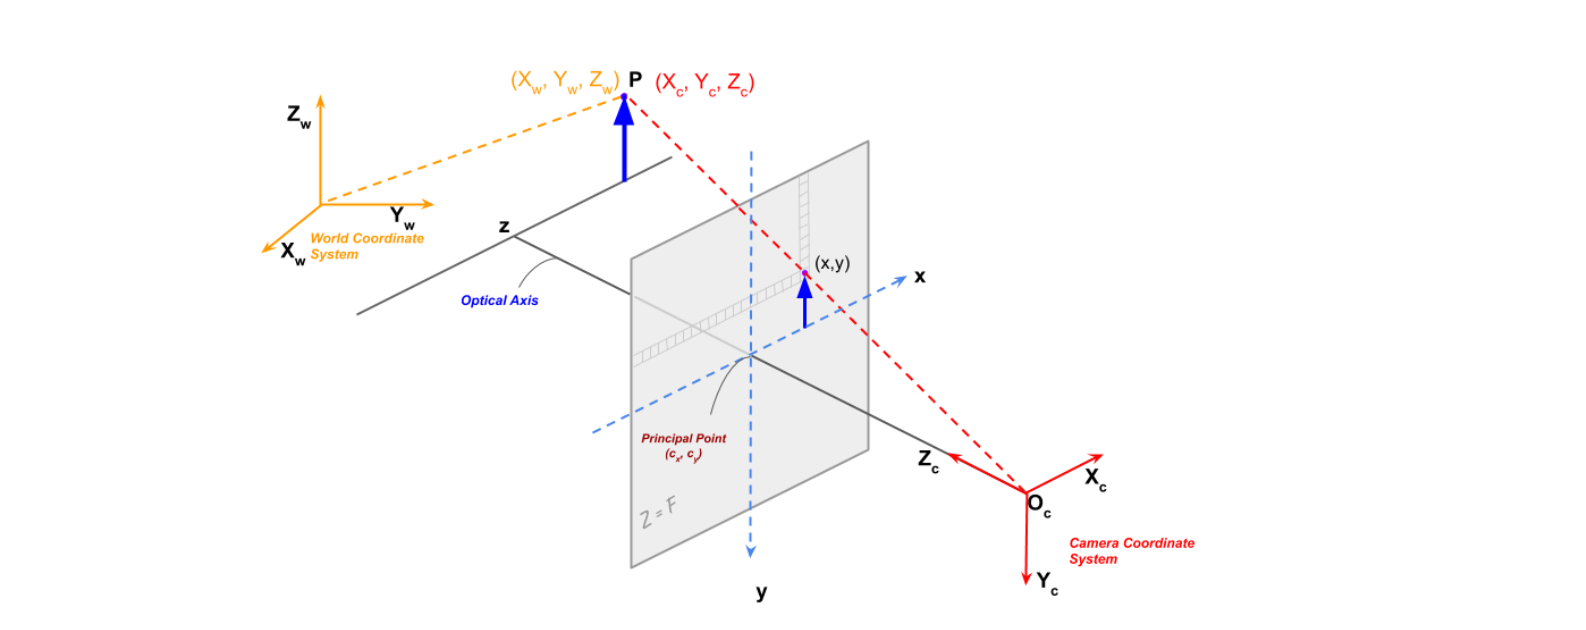

Project image $(x, y)$ of the 3D point $(X_c, Y_c, Z_c)$ coordinates:

$$x = f \frac{X_c}{Z_c}$$
$$y = f \frac{Y_c}{Z_c}$$


where $f$ is a focal length


The above two equations can be rewritten in matrix form as follows:

$$\begin{pmatrix}
x'\\
y'\\
z'
\end{pmatrix} = 
\begin{pmatrix}
f & 0 & 0\\
0 & f & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
X_c \\
Y_c \\
Z_c
\end{pmatrix}$$



The matrix $K$ shown below is called the **Intrinsic Matrix** and contains the intrinsic parameters of the camera.

$$K = \begin{pmatrix}
f & 0 & 0\\
0 & f & 0 \\
0 & 0 & 1
\end{pmatrix}$$


1) the pixels in the image sensor may not be square, and so we may have two different focal lengths $f_x$ and $f_y$.

2) The optical center $(c_x, c_y)$ of the camera may not coincide with the center of the image coordinate system.

3) there may be a small skew $\gamma$ between the $x$ and $y$ axes of the camera sensor.

Taking all the above into account, the camera matrix can be re-written as.


$$K = \begin{pmatrix}
f_x & \gamma & c_x\\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix}$$


However, in the above equation, the $x$ and $y$ pixel coordinates are with respect to the center of the image. However, while working with images the origin is at the top left corner of the image.

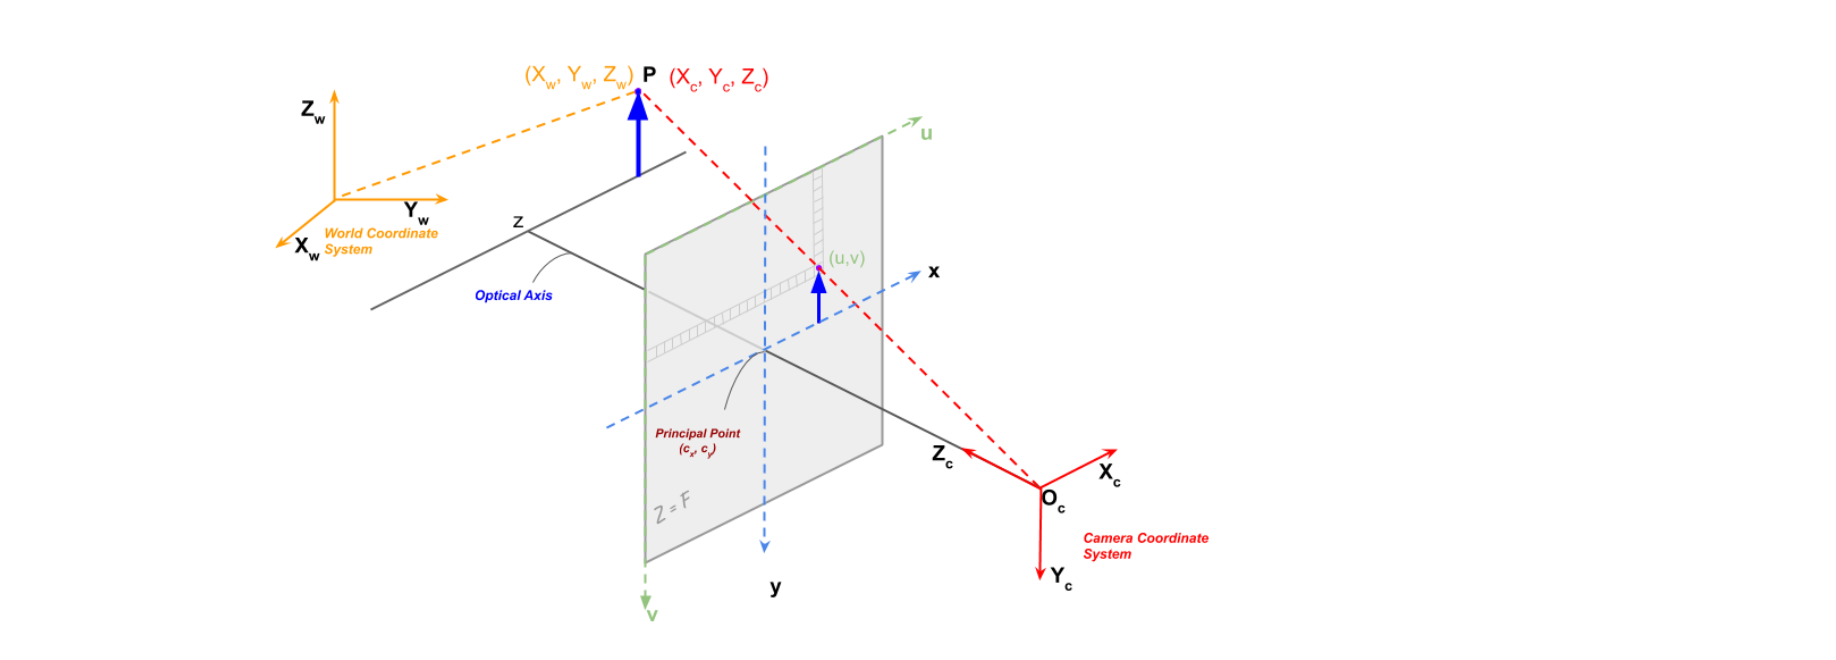

Let's represent the image coordinates by (u, v)

$$\begin{pmatrix}
u'\\
v'\\
w'
\end{pmatrix} = 
\begin{pmatrix}
f_x & \gamma & c_x\\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
X_c \\
Y_c \\
Z_c
\end{pmatrix}$$

Where, $ u = \frac{u'}{w'}$, $v = \frac{v'}{w'}$


$$\begin{pmatrix}
u\\
v\\
1
\end{pmatrix} = 
\begin{pmatrix}
S_x & \gamma & c_x\\
0 & S_y & c_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
f & 0 & 0\\
0 & f & 0 \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
X_c \\
Y_c \\
Z_c \\
1
\end{pmatrix}$$

$$\begin{pmatrix}
u\\
v\\
1
\end{pmatrix} = 
K_sK_f \Pi_0
\begin{pmatrix}
X_c \\
Y_c \\
Z_c \\
1
\end{pmatrix}$$

### Summary

Projecting a 3D point in world coordinate system to camera pixel coordinates is done in two steps.

1) The 3D point is transformed from world coordinates to camera coordinates using the **Extrinsic Matrix** which consists of the Rotation and translation between the two coordinate systems.

2) The new 3D point in camera coordinate system is projected onto the image plane using the **Intrinsic Matrix** which consists of internal camera parameters like the focal length, optical center, etc.
    

$$\begin{pmatrix}
u\\
v\\
1
\end{pmatrix} = 
\begin{pmatrix}
f_x & \gamma & c_x\\
0 & f_y & c_y \\
0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
R | t
\end{pmatrix}
\begin{pmatrix}
X_w\\
Y_w\\
Z_w \\ 
1
\end{pmatrix}$$

**Exercise 4:** Make perspective projection
    
1) Choose random camera pose

2) Using provided K, compute camera matrix for this pose

3) Compute projected points

4) Finish *project_to_camera()* in *CameraPose* class (copy your code)

In [ ]:
cube = trimesh.creation.box()

cube.vertices -= cube.center_mass

points = trimesh.sample.sample_surface(cube, 30000)[0]  # (N,3)
colors = k3d.helpers.map_colors(
    points, k3d.colormaps.basic_color_maps.Rainbow, [-3, 3]
).astype(np.uint32)
colors = colors[:, 0]

illustrate_mesh(cube)

In [ ]:
# intrinsics
K = np.array(
    [[10,   0.        ,   0.        , 0.],
     [  0.        , 10,   0.        , 0.],
     [  0.        ,   0.        ,   1.        , 0.]]
)

In [ ]:
camera_pose = CameraPose.from_camera_origin([0, 0, 1])
plot = illustrate_points(cube.vertices, size=0.1)
vectors = illustrate_camera(camera_pose, w=0.01, use_head=True)
plot += vectors
plot

In [ ]:
### Your code here ###

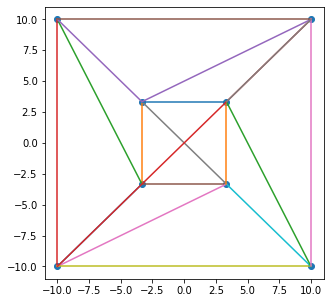

In [38]:
def illustrate_projected_points(xy):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    x, y = xy.T
    ax.scatter(x, y)
    
    for edge in cube.edges_unique:
        ax.plot(x[edge], y[edge])
    plt.show()


illustrate_projected_points(xy)

# 3. Raycasting

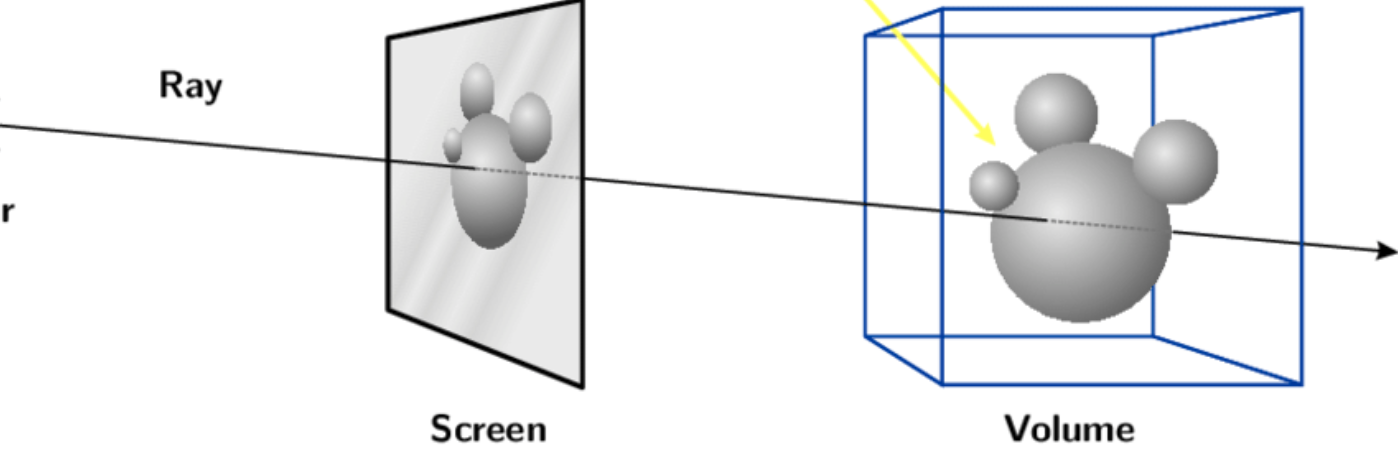

In [ ]:
import numpy as np
from trimesh.ray.ray_pyembree import RayMeshIntersector


class RaycastingImaging:
    def __init__(self, resolution_image=512, resolution_3d_factor=10.24):
        """
        :param image_resolution: image resolution in pixels
        :type image_resolution: int or tuple of ints
        :param resolution_3d: pixel 3d resolution in mm/pixel
        :type resolution_3d: float
        """
        self.resolution_image = resolution_image
        self.resolution_3d = resolution_3d_factor / resolution_image

        self.rays_screen_coords, self.rays_origins, self.rays_directions = None, None, None

    def __del__(self):
        del self.rays_screen_coords
        del self.rays_origins
        del self.rays_directions

    def prepare(self, radius=1.0):
        """Creates an array of rays and ray directions used for mesh raycasting.
        :param radius: Z coordinate for the rays origins
        :type resolution_3d: float
        :return:
            rays_screen_coords:     (W * H, 2): screen coordinates for the rays
            rays_origins:           (W * H, 3): world coordinates for rays origins
            ray_directions:         (W * H, 3): unit norm vectors pointing in directions of the rays
        """
        if isinstance(self.resolution_image, tuple):
            assert len(self.resolution_image) == 2
            image_width, image_height = self.resolution_image
        else:
            image_width, image_height = self.resolution_image, self.resolution_image        

        # generate an array of screen coordinates for the rays
        # (rays are placed at locations [i, j] in the image)
        self.rays_screen_coords = np.mgrid[0:image_height, 0:image_width].reshape(
            2, image_height * image_width).T    # [h, w, 2]

        # place rays physically in locations determined by screen coordinates,
        # then shift so that camera origin is in the midpoint in the image,
        # and linearly stretch so each pixel takes exactly resolution_3d space
        screen_aspect_ratio = image_width / image_height
        self.rays_origins = (self.rays_screen_coords / np.array([[image_height, image_width]]))   # [h, w, 2], in [0, 1]
        factor = image_height / 2 * self.resolution_3d
        self.rays_origins[:, 0] = (-2 * self.rays_origins[:, 0] + 1) * factor  # to [-1, 1] + aspect transform
        self.rays_origins[:, 1] = (-2 * self.rays_origins[:, 1] + 1) * factor * screen_aspect_ratio
        self.rays_origins = np.concatenate([
            self.rays_origins,
            radius + np.zeros_like(self.rays_origins[:, [0]])
        ], axis=1)  # [h, w, 3]

        # ray directions are always facing towards Z axis
        self.rays_directions = np.tile(np.array([0, 0, -1]), (self.rays_origins.shape[0], 1))
        
    def get_image(self, mesh): #, features):
        if any(value is None for value in [self.rays_screen_coords, self.rays_origins, self.rays_directions]):
            raise Exception('Raycasting was not prepared')

        # get a point cloud with corresponding indexes
        intersector = RayMeshIntersector(mesh)
        mesh_face_indexes, ray_indexes, points = intersector.intersects_id(
            ray_origins=self.rays_origins, ray_directions=self.rays_directions,
            multiple_hits=False, return_locations=True)

        # extract normals
        normals = mesh.face_normals[mesh_face_indexes]

        mesh_face_indexes = np.unique(mesh_face_indexes)
        mesh_vertex_indexes = np.unique(mesh.faces[mesh_face_indexes])
        direction = self.rays_directions[ray_indexes][0]
        return ray_indexes, points, normals, direction, mesh_vertex_indexes, mesh_face_indexes

    def points_to_image(self, points, ray_indexes, assign_channels=None):
        xy_to_ij = self.rays_screen_coords[ray_indexes]
        # note that `points` can have many data dimensions
        if None is assign_channels:
            assign_channels = [2]
        data_channels = len(assign_channels)
        image = np.zeros((self.resolution_image, self.resolution_image, data_channels))
        image[xy_to_ij[:, 0], xy_to_ij[:, 1]] = points[:, assign_channels]
        return image.squeeze()


def make_noise(points, normals, scale=0.0, z_direction=None, **kwargs):
    assert z_direction is not None
    noise = np.random.normal(size=(len(points), 1), scale=scale) * z_direction
    noisy_points = points + noise * z_direction
    return noisy_points



In [ ]:
raycaster = RaycastingImaging(resolution_image=512, resolution_3d_factor=20)
raycaster.prepare(radius=np.max(mesh.bounding_box.extents) + 1.0)

In [ ]:
(ray_indexes,
 points,
 normals,
 direction,
 mesh_vertex_indexes,
 mesh_face_indexes) = raycaster.get_image(mesh)

noisy_points = make_noise(points, normals, z_direction=np.array([0., 0., -1.]))
depth_map = raycaster.points_to_image(noisy_points, ray_indexes)
normals_image = raycaster.points_to_image(normals, ray_indexes, assign_channels=[0, 1, 2])

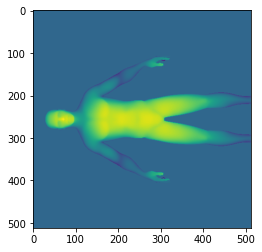

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(depth_map)

In [ ]:
plot = illustrate_mesh(mesh)

vectors = illustrate_camera(camera_poses[0], w=0.01, use_head=True)
plot += vectors
plot

**Exercise 5:** Get depth map from random camera pose

**Hint:** transform mesh

In [ ]:
def get_depth_map(mesh, camera_pose):
    
    ### Your code here ###

    (ray_indexes,
     points,
     normals,
     direction,
     mesh_vertex_indexes,
     mesh_face_indexes) = raycaster.get_image(mesh_)

    noisy_points = make_noise(points, normals, z_direction=np.array([0., 0., -1.]))
    depth_map = raycaster.points_to_image(noisy_points, ray_indexes)
    return depth_map

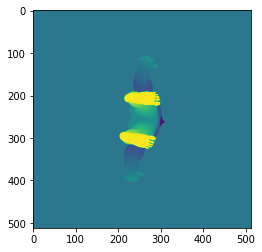

In [62]:
plt.imshow(get_depth_map(mesh, camera_poses[99]))

**Exercise 6:** Having _depth_map_ and _camera_origin_, get point cloud

In [ ]:
camera_pose = camera_poses[50]
depth_map = get_depth_map(mesh, camera_pose)

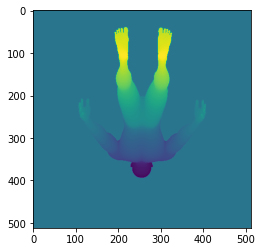

In [94]:
plt.imshow(depth_map)

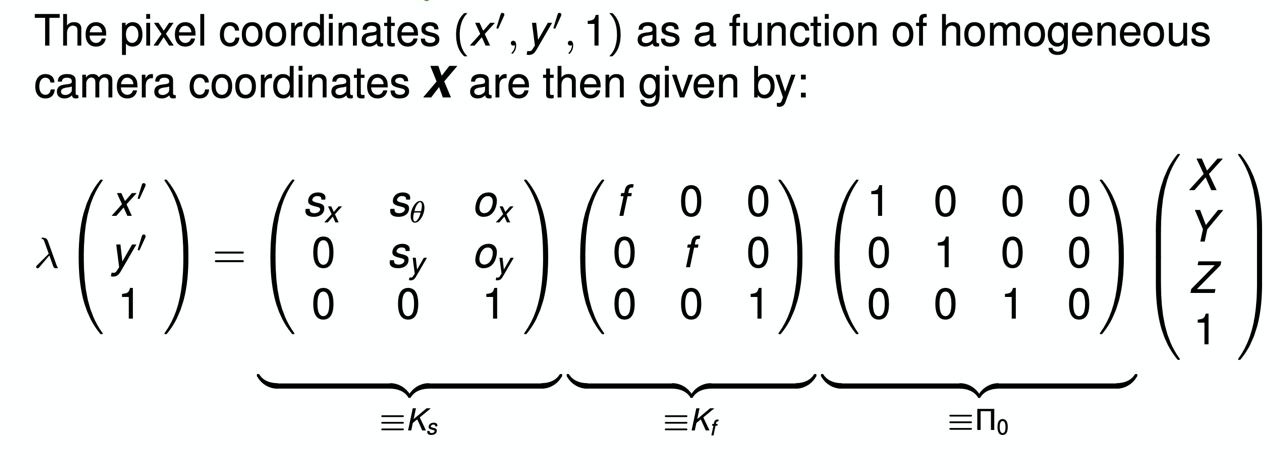

In [ ]:
S_x = <...>
S_y = <...>

O_x = <...>
O_y = <...>

In [ ]:
points = []
for i in range(depth_map.shape[0]):
    for j in range(depth_map.shape[1]):
        u = <...>
        v = <...>

        depth = depth_map[i, j]
        if depth != 0:
            points.append([u, v, depth])

In [ ]:
illustrate_points(points, size=.1)

In [ ]:
points_w = camera_pose.transform_camera_to_world(points)

illustrate_points(points_w, size=.1)